# Introduction to phylogenetic comparative methods in R
Goettingen 2023  
Andrew Hipp, ahipp@mortonarb.org  
Tutorial 03a: Model evaluation using information criteria  
Use [static view in nbviewer](https://nbviewer.org/github/andrew-hipp/workshops/blob/master/2023-goettingen/Wk3-EvolutionaryProcess/03a.models-ic.ipynb) if you are not working directly in Jupyter notebooks.

### Session 3a: Working with information criteria

This tutorial has two goals: 

1. Give you a chance to work through the material from today's lecture on likelihood and information criteria, implementing things to make sure you understand what you are doing. 
2. Practice moving your code into functions.

We will work through these together. If you have experience writing functions, some of this will be elementary. But As always, I encourage you to try implementing these methods on your own dataset. It is most instructive to try to push your own data through a method, both because there are usually formatting difficulties to work through and because the results will be most sensible to you if you have prior expectations.


2. Write a function that takes a vector of AIC or AICc values and returns a vector of weights.
3. Write a wrapper function that calls both 1 and 2 above on a set of regression models, and returns model-averaged estimates for the model parameters.

# 1. A function to return AIC and AICc values on a single model

Here, we'll write a function to take a single fitted model and return the AIC and AICc value. We'll use:  
* ```logLik``` to extract the log likelihood from the fitted object --- as we discussed in lecture, ```gls```, ```lm```, and many other modeling functions are associated with a `logLik` method    
* ```attr(logLik(obj), 'df')``` to get the number of free model parameters, and  
* ```attr(logLik(obj), 'nall')``` to get the sample size.

In [1]:
aic <- function(x = NA, ...) { # specify the function
    if(!hasArg(L)) {L <- logLik(x)} else {
        L = list(...)$L
    } # get the log-likelihood
    dev <- -2 * L # get the deviance
    if(!hasArg(K)) {K = attr(L, 'df')} else {
        K = list(...)$K
    } # get the number of free parameters
    aic <- dev + 2*K
    
    if(!hasArg(n)) {n = attr(L, 'nall')} else {
        n = list(...)$n
    } # get number of data points
    aic.c <- aic + (2 * K * (K + 1)) / (n - K - 1)
    
    out <- list(aic = aic, aic.c = aic.c, n = n, K = K, lnL = L)
    
    # and in case you used nlme to do GLS:
    if('modelStruct' %in% names(x)) out$param = as.numeric(x$modelStruct)
    
    class(out) <- 'aic'
    return(out)
}

dput(aic, 'aic.R') # saving it, b/c this will be a handy function later

Let's give our function a try and see how it works. Let's go back to OLS for a second, because it's rather straightforward to analyze. We'll simulate some data, as we did last week, and ask this question: does a model with a slope fit the data better than a model without a slope? This is a very basic question in model fitting, asking whether a predictor is a statistically important predictor of a response. First, let's simulate our data:

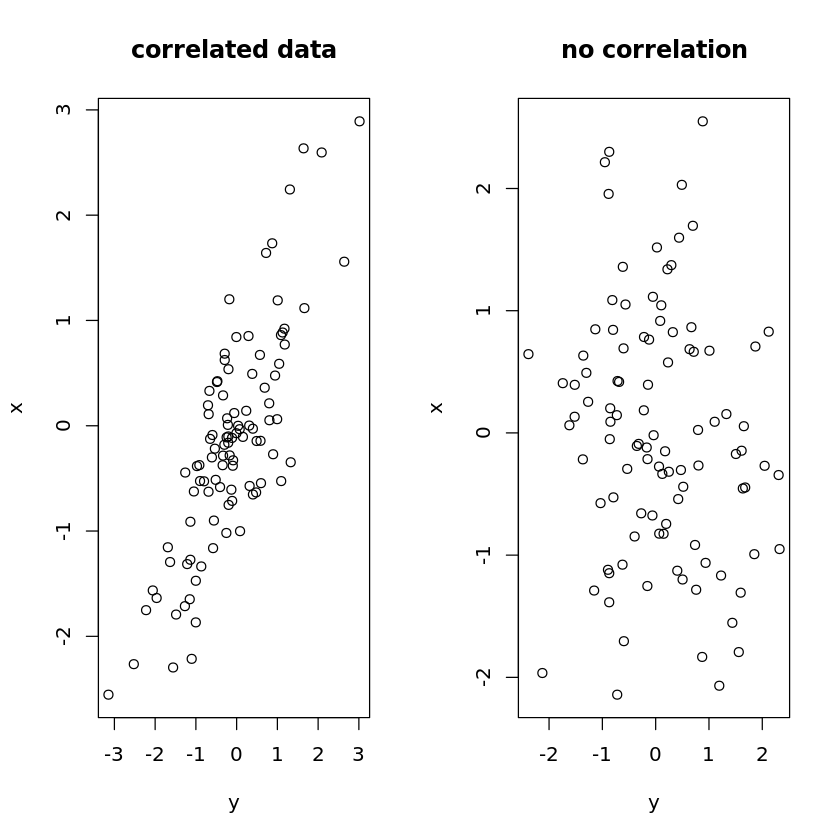

In [2]:
library(MASS)
dat.cor <- mvrnorm(100, c(0,0), Sigma = matrix(c(1, .8, .8, 1), 2, 2, byrow=T))
dat.noCor <- mvrnorm(100, c(0,0), Sigma = matrix(c(1,0,0,1), 2,2,byrow = T))
colnames(dat.cor) <- colnames(dat.noCor) <- c('y', 'x')
layout(matrix(1:2, 1, byrow = T))
plot(dat.cor, main = 'correlated data')
plot(dat.noCor, main = 'no correlation')

Then, let's fit two models to each dataset: one with an intercept and a variance (_K_ = 2 free parameters); one with an intercept, variance, and slope (_K_ = 3).

In [3]:
## it will be easier if our data are in a data frame, and in a list so our workspace doesn't get so cluttered:

dat <- list(
    cor = data.frame(dat.cor),
    noCor = data.frame(dat.noCor)
    )

# and let's put our results into a list as well
ols.lm <- list(
    cor.corMod = lm(y ~ x, dat$cor),
    cor.noCorMod = lm(y ~ 1, dat$cor),
    noCor.corMod = lm(y ~ x, dat$noCor),
    noCor.noCorMod = lm(y ~ 1, dat$noCor)
)

message('example information you get from one of these objects:')
message('first the summary:')
summary(ols.lm$cor.corMod)

message('then a list of the objects inside to explore as you like:')
names(ols.lm$cor.corMod)

example information you get from one of these objects:

first the summary:




Call:
lm(formula = y ~ x, data = dat$cor)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1478 -0.5238 -0.0087  0.4138  1.6005 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.004706   0.062020   0.076     0.94    
x           0.802490   0.058787  13.651   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.612 on 98 degrees of freedom
Multiple R-squared:  0.6554,	Adjusted R-squared:  0.6518 
F-statistic: 186.3 on 1 and 98 DF,  p-value: < 2.2e-16


then a list of the objects inside to explore as you like:



[1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "xlevels"       "call"          "terms"         "model"

And now, let's get our aic's:

In [4]:
ols.aic <- sapply(ols.lm, aic)
print(ols.aic)
message('Doing just one to see what our aic function returns:')
aic(ols.lm$cor.corMod)

      cor.corMod cor.noCorMod noCor.corMod noCor.noCorMod
aic   189.5555   294.0784     294.0989     294.1173      
aic.c 189.8055   294.2021     294.3489     294.241       
n     100        100          100          100           
K     3          2            3            2             
lnL   -91.77774  -145.0392    -144.0495    -145.0586     


Doing just one to see what our aic function returns:



$aic
'log Lik.' 189.5555 (df=3)

$aic.c
'log Lik.' 189.8055 (df=3)

$n
[1] 100

$K
[1] 3

$lnL
'log Lik.' -91.77774 (df=3)

attr(,"class")
[1] "aic"

Questions:
1. You can only compare models within datasets. Which comparisons should you make?
1. Which is the better-supported model for each dataset? How conclusive is each comparison?

# 2. A function that takes a vector of AIC or AICc values and returns a vector of weights.

First, we'll code aic weights following [today's lecture](https://github.com/andrew-hipp/workshops/blob/master/2023-goettingen/ZZZ-presentations/Wk3-1_models/Wk3-1.models.pdf) (slides 16-22):

In [5]:
aic_w <- function(x, ...) {
    aic.lnL <- exp(-0.5 * (x - min(x)))
    aic_w <- aic.lnL / sum(aic.lnL)
    return(aic_w)
}

That was pretty easy. This just takes a vector of AIC values (or AICc or BIC) and returns the AIC weights.

Let's see how it works, using [O'Meara 2006](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.0014-3820.2006.tb01171.x), Table 4 as our input. We'll use the final model set tested as an example. First, create a vector of the AIC values (you could also use AICc, but we'll just stick with AIC for this example):

In [6]:
omeara.aic <- c(
    m1111 = 12.4,
    m1121 = 10.1,
    m1222 = 4.9,
    m1212 = 3.2,
    m1123 = 11.1,
    m1232 = 0,
    m1234 = 1.7
)

message('aic weights')
aic_w(omeara.aic) |> round(3) |> sort() |> print()

aic weights



m1111 m1123 m1121 m1222 m1212 m1234 m1232 
0.001 0.002 0.004 0.050 0.117 0.247 0.579 


Note that O'Meara's table reports the delta AICs (AIC - minimum AIC), so that the lowest AIC in each list is 0. This is fine, because AIC only makes sense relative to the full set of models being evaluated. You can demonstrate this to yourself if you like by comparing the results of `aic_w(omeara.aic)` with `aic_w(omeara.aic + N)`, where _N_ is any number you like.

As you look at the results, consider how you would interpret them. How strong is the evidence for the single best model? Is it strong enough that you would want to place all your eggs in that basket? How many models do you have to include to reach 0.95 cumulative model support? Are those all acceptable models?

# 3. A function to run aic for a set of models
Now that you have the two basic functions --- `aic` to run on a model, `aic_w` to run on a vector of aic values --- let's write a third function to call them both. This iterative process is a useful way to work your way through analysis: trying out individual code scraps on the command line, aggregating code into small functions, aggregating functions into larger functions that run all the pieces. One advantage to working this way is that smaller functions are easier to understand and debug.

So, let's make our small function:

In [7]:
aic_w_modelSet <- function(x, which.use = 'aic', ...) {
    aic.set <- lapply(x, aic)
    aic.set <- sapply(aic.set, function(x) x[[which.use]])
    out <- aic_w(aic.set, ...)
    return(out)
}
                      
message('trying this out on our simple example above, just the correlated data')

aic_w_modelSet(ols.lm[1:2]) |> round(5) |> sort() |> print()

trying this out on our simple example above, just the correlated data



cor.noCorMod   cor.corMod 
           0            1 


Our example sends just the first two objects in `ols.lm`, which are the two fitted models from the correlated data. The results show that the 3-parameter model (slope, intercept, and variance) fits _much_ better than the 2-parameter model (intercept and variance only). The former carries essentially all the weight (> 0.9999).

Consider a limitation of AIC as a model-evaluation framework:

In [8]:
aic_w_modelSet(ols.lm[3:4]) |> round(5) |> sort() |> print()

noCor.noCorMod   noCor.corMod 
       0.49771        0.50229 


Should we really think of the correlated model as ultra-conclusive with correlated data, and the non-correlated model as _pretty_ conclusive with uncorrelated data?

# An example with phylogenetic regression
Here, we'll try our functions out with a phylogenetic regression problem, adding something we just started discussing last week (and that we'll address more in today's second lecture): simultaneously fitting regression parameters and a parameter estimating phylogenetic autocorrelation (we'll use Pagel's $\lambda$). First, let's generate our tree and data:

Loading required package: ape

Loading required package: phytools

Loading required package: maps



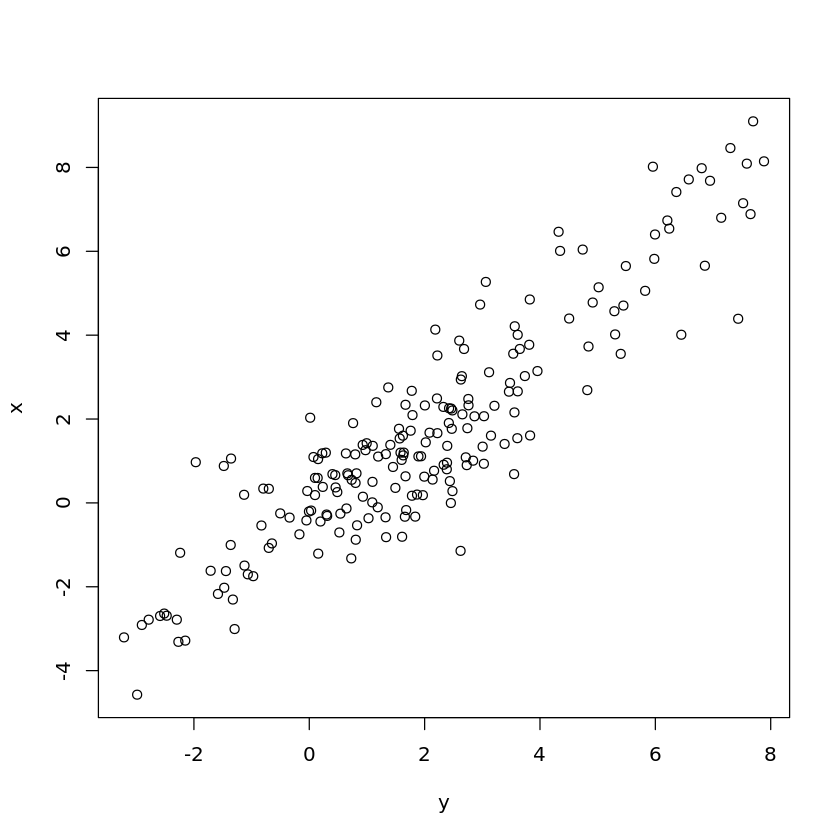

In [9]:
library(geiger)

# simulate a tree
tr <- pbtree(n = 200)

# then, simulate data on the tree, with less phylogenetic autocorrelation than the tree implies
# we'll use Pagel's lambda to do this
tr2 <- rescale(tr, model = 'lambda', 0.9)
dat <- sim.char(tr2, matrix(c(1,0.8,0.8,1),2,2, byrow = T))[, , 1] |>
    as.data.frame()

# plot the data:
names(dat) <- c('y','x')
plot(dat)

We'll use the `gls` function in nlme for regression. This function requires a correlation structure, specified with the `correlation` argument. There are a few phylogenetic correlation structures coded in the ape package; to see them, type `?corClasses` and choose the documentation for "Phylogenetic Correlation Structures {ape}". The correlation structures takes a four arguments:  
* `value`: the starting value of the parameter. In `corLambda`, this parameter is Pagel's $\lambda$. In `corBrown`, this is a scalar on the entire phylogeny (which is scalar on the phylogenetic variance)
* `phy`: the phylogeny in `phylo` format
* `form` = from the documentation, "a one sided formula of the form ~ t, or ~ t | g, specifying
          the taxa covariate t and, optionally, a grouping factor g. A
          covariate for this correlation structure must be character
          valued, with entries matching the tip labels in the
          phylogenetic tree. When a grouping factor is present in form,
          the correlation structure is assumed to apply only to
          observations within the same grouping level; observations
          with different grouping levels are assumed to be
          uncorrelated." [default = ~1]
* `fixed` = whether to estimate the parameter or keep it fixed [default = FALSE].

First, bring in the library we need and add the tip labels to the data.frame so we can specify the form properly:

In [10]:
library(nlme)
dat$spp <- tr$tip.label

Then, specify the models. The first is a standard GLS regression, with the phylogeny exactly as it is. This is the same as doing phylogenetic independent contrasts:

In [11]:
models <- list(y.x.brown = gls(y ~ x, dat, correlation = corBrownian(1, tr, form = ~spp)))

This is a model with _K_ = 3 free parameters. Then, we'll do the same model, but allowing Pagel's $\lambda$ to vary freely. This adds one free parameter:

In [12]:
models$y.x.pagel = gls(y ~ x, dat, correlation = corPagel(1, tr, form = ~spp))

Now, let's do one with Brownian motion, so allowing for phylogenetic autocorrelation, but no predictor. Just for fun, we'll let lambda vary again. This is a _K_ = 3 model (what parameters?):

In [13]:
models$y.brown = gls(y ~ 1, dat, correlation = corPagel(1, tr, form = ~spp))

Finally, a star phylogeny: no phylogenetic correlation at all. For comparison, we'll throw in the OLS regression (which should have the same log-likelihood. Both should have 3 free parameters (let's see if these are calculated correctly in R):

In [14]:
models$y.x.star = gls(y ~ x, dat, correlation = corPagel(0, tr, form = ~spp, fixed = TRUE))
models$ols = lm(y ~ x, dat)

Now, let's see what the model results look like:

In [15]:
message('model outputs')
sapply(models, function(x) aic(x)[c('aic', 'n', 'K', 'lnL', 'param')]) |> print()

message('aic weights')
aic_w_modelSet(models) |> sort() |> round(10) |> print()

model outputs



      y.x.brown y.x.pagel y.brown   y.x.star  ols      
aic   605.8312  486.5159  681.1523  601.1186  592.4618 
n     200       200       200       200       200      
K     3         4         3         3         3        
lnL   -299.9156 -239.258  -337.5762 -297.5593 -293.2309
param 1         0.8970786 0.939136  0         NULL     


aic weights



  y.brown y.x.brown  y.x.star       ols y.x.pagel 
        0         0         0         0         1 


You'll notice first off that the last two models do _not_ have identical lnL after all. Why is this? I don't actually know. Just for fun, let's throw one more model in there, directly transforming the tree:

In [16]:
models$y.x.star.forced = gls(y ~ x, dat, correlation = corBrownian(1, rescale(tr, 'lambda', 0), form = ~spp))
sapply(models, function(x) aic(x)[c('aic', 'n', 'K', 'lnL', 'param')]) |> print()

      y.x.brown y.x.pagel y.brown   y.x.star  ols       y.x.star.forced
aic   605.8312  486.5159  681.1523  601.1186  592.4618  601.1186       
n     200       200       200       200       200       200            
K     3         4         3         3         3         3              
lnL   -299.9156 -239.258  -337.5762 -297.5593 -293.2309 -297.5593      
param 1         0.8970786 0.939136  0         NULL      1              


... which gives us the same thing as forcing $\lambda$ to be zero in the GLS estimation. So I'm not sure.

But you can see how you do this. The Pagel model is strongly supported as the best fit no matter how you slice it. Now, does that affect your inference about the model parameters? Let's compare the two best models to see:

In [17]:
message('unscaled GLS')
summary(models$y.x.brown) |> print()

message('rescaled GLS')
summary(models$y.x.pagel)

unscaled GLS



Generalized least squares fit by REML
  Model: y ~ x 
  Data: dat 
       AIC     BIC    logLik
  605.8312 615.696 -299.9156

Correlation Structure: corBrownian
 Formula: ~spp 
 Parameter estimate(s):
numeric(0)

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 0.7480691 0.8796278  0.850438  0.3961
x           0.7120646 0.0474973 14.991691  0.0000

 Correlation: 
  (Intr)
x -0.069

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.36840162 -0.28800906  0.02885528  0.32956075  1.43038728 

Residual standard error: 2.48968 
Degrees of freedom: 200 total; 198 residual


rescaled GLS



Generalized least squares fit by REML
  Model: y ~ x 
  Data: dat 
       AIC     BIC   logLik
  486.5159 499.669 -239.258

Correlation Structure: corPagel
 Formula: ~spp 
 Parameter estimate(s):
   lambda 
0.8970786 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 0.6085015 0.4515601  1.347554  0.1793
x           0.8181221 0.0435639 18.779806  0.0000

 Correlation: 
  (Intr)
x -0.126

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.52369238 -0.49584908 -0.01418212  0.51612443  2.42246944 

Residual standard error: 1.335438 
Degrees of freedom: 200 total; 198 residual

Compare the regression coefficients and standard errors to see if they are significantly different (multiplying std.error by 1.96 is a conventional way of getting a 95% CI on your coefficients). GLS is considered to be BLUE (the best linear unbiased estimator) for a linear regression, so long as the the covariance matrix is properly specified. Using the $\lambda\ scalar is one way to improve the fit between your covariance matrix and your data.

# For further reading
* Blomberg SP, Lefevre JG, Wells JA, Waterhouse M. 2012. Independent Contrasts and PGLS Regression Estimators Are Equivalent. Systematic Biology 61: 382–391.
* Anderson DR, Burnham KP. 2002. Avoiding Pitfalls When Using Information-Theoretic Methods. The Journal of Wildlife Management 66: 912–918.
* Burnham KP, Anderson DR. 2002. Model selection and multimodel inference: a practical information-theoretic approach. New York: Springer.
* Revell LJ. 2010. Phylogenetic signal and linear regression on species data. Methods in Ecology and Evolution 1: 319–329.
